# Access data from the NECOFS (New England Coastal Ocean Forecast System) via OPeNDAP

Demonstration using the NetCDF4-Python library to access velocity data from a triangular grid ocean model (FVCOM) via OPeNDAP, specifying the desired URL, time, layer and lat/lon region of interest.  The resulting plot of forecast velocity vectors over color-shaded bathymetry is useful for a variety of recreational and scientific purposes. 

NECOFS (Northeastern Coastal Ocean Forecast System) is run by groups at the University of Massachusetts Dartmouth and the Woods Hole Oceanographic Institution, led by Drs. C. Chen, R. C. Beardsley, G. Cowles and B. Rothschild. Funding is provided to run the model by the NOAA-led Integrated Ocean Observing System and the State of Massachusetts.

NECOFS is a coupled numerical model that uses nested weather models, a coastal ocean circulation model, and a wave model. The ocean model is a volume-mesh model with horizontal resolution that is finer in complicated regions. It is layered (not depth-averaged) and includes the effects of tides, winds, and varying water densities caused by temperature and salinity changes.

* Model description: http://fvcom.smast.umassd.edu/research_projects/NECOFS/model_system.html
* THREDDS server with other forecast and archive products: http://www.smast.umassd.edu:8080/thredds/catalog.html

In [1]:
# swim route
lon_track = (-70.890150, -70.927933, -70.951417, -70.976217, -70.999150, -71.034850)
lat_track = (42.327400, 42.316150, 42.314800, 42.309300, 42.322633, 42.328700)

```python
# GOM3 GRID
url = "http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc"
```

In [2]:
from netCDF4 import Dataset


# MassBay GRID
url = (
    "http://www.smast.umassd.edu:8080/thredds/dodsC/"
    "FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc"
)

nc = Dataset(url)
nc.variables.keys()

odict_keys(['x', 'y', 'lon', 'lat', 'xc', 'yc', 'lonc', 'latc', 'siglay', 'h', 'nv', 'time', 'Times', 'zeta', 'nbe', 'aw0', 'awx', 'awy', 'u', 'v', 'ww', 'ua', 'va', 'temp', 'salinity', 'fvcom_mesh'])

In [3]:
# take a look at the "metadata" for the variable "u"

print(nc["temp"])

<class 'netCDF4._netCDF4.Variable'>
float32 temp(time, siglay, node)
    long_name: temperature
    standard_name: sea_water_potential_temperature
    units: degrees_C
    grid: fvcom_grid
    coordinates: time siglay lat lon
    type: data
    coverage_content_type: modelResult
    mesh: fvcom_mesh
    location: node
unlimited dimensions: time
current shape = (145, 10, 98432)
filling off



In [80]:
from datetime import datetime, timedelta


# Desired time for snapshot in UTC 
# ....right now (or some number of hours from now) ...
start = datetime.utcnow() + timedelta(hours=48)

# ... or specific time (UTC)    
start = datetime(2019, 8, 17, 18, 0, 0)  # Note: EDT = UTC - 4 hours , EST = UTC -5 hours

In [81]:
from cftime import date2index


# Get desired time step
time_var = nc["time"]
itime = date2index(start, time_var, select="nearest")

# Get lon,lat coordinates for nodes (depth)
lat = nc["lat"][:]
lon = nc["lon"][:]

# Get lon,lat coordinates for cell centers (depth)
latc = nc["latc"][:]
lonc = nc["lonc"][:]

# Get Connectivity array
nv = nc["nv"][:].T - 1

# Get depth
h = nc["h"][:]  # depth

In [82]:
import matplotlib.tri as Tri


tri = Tri.Triangulation(lon, lat, triangles=nv)

In [83]:
from cftime import num2date


dtime = num2date(time_var[itime], time_var.units)
daystr = dtime.strftime("%Y-%b-%d %H:%M")

print(f"Time in UTC: {daystr}")

Time in UTC: 2019-Aug-17 18:00


In [84]:
# get current at layer [0 = surface, -1 = bottom]

ilayer = 0

u = nc["u"][itime, ilayer, :]
v = nc["v"][itime, ilayer, :]
t = nc["temp"][itime, ilayer, :]

u = u*1.94  # convert m/s to knots
v = v*1.94  # convert m/s to knots
t = 32 + t*9/5  # convert from C to F

In [85]:
import numpy as np


# boston light swim
levels = np.arange(66, 76, 1.)  # temperature contours to plot [48 to 65 in intervals of 1]
region = [-71.05, -70.82, 42.28, 42.38] # region to plot
maxvel = 1.0 # velocity arrow scale
subsample = 9  # subsampling of velocity vectors

In [86]:
# find velocity points in bounding box

ind = np.argwhere(
    (lonc >= region[0]) &
    (lonc <= region[1]) &
    (latc >= region[2]) &
    (latc <= region[3])
)

In [87]:
np.random.shuffle(ind)
Nvec = int(len(ind) / subsample)
idv = ind[:Nvec]

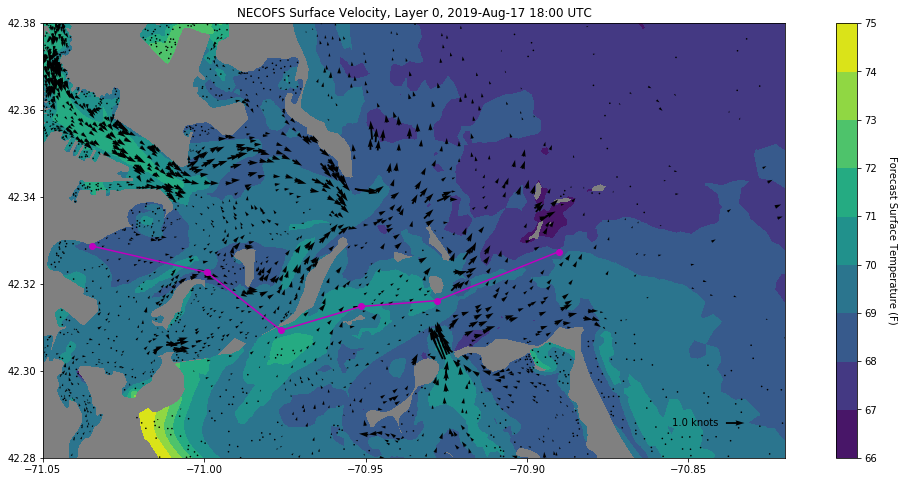

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt


# tricontourf plot of water depth with vectors on top
mercator = 1/np.cos(lat.mean()*np.pi/180)
fig, ax = plt.subplots(
    figsize=(18, 8),
    subplot_kw={"aspect": mercator}
)


cs = ax.tricontourf(tri, t, levels=levels) #We need to adjust the bias and the levels later.
#cs = ax.tricontourf(tri, t)
ax.axis(region)
ax.set_facecolor("0.5")
cbar = fig.colorbar(cs)
cbar.set_label("Forecast Surface Temperature (F)", rotation=-90, labelpad=20)
Q = ax.quiver(lonc[idv], latc[idv], u[idv], v[idv], scale=40)
maxstr = f"{maxvel:3.1f} knots"
qk = ax.quiverkey(Q, 0.92, 0.08, maxvel, maxstr, labelpos="W")
ax.set_title(f"NECOFS Surface Velocity, Layer {ilayer:d}, {daystr} UTC")
ax.plot(lon_track, lat_track, "m-o");